# Essential Imports

## Imports

In [1]:
# -------- These settings suppress those pesky VSCode PyLance errors. ---------
# pyright: reportMissingModuleSource=false
# pyright: reportGeneralTypeIssues=false

In [2]:
# Essentials
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
# Project Specific Imports
import statsmodels.api as sm 

In [4]:
# Configurations & Settings
from warnings import filterwarnings
filterwarnings('ignore')

pd.set_option('display.width', 1000)
sns.set_style(style='ticks')

## Utility Functions

In [5]:
# Some Utility Functions

def MapFeatureVals(df, colList, mapDict):
    if type(colList)==str:
        colList = [colList] #Ensure colList is a list. 
    for col in colList:
        df[col].replace(mapDict, inplace=True)

# ==============================================
def MakeDummyCols(df, col):
    cols = pd.get_dummies(df[col])
    df = pd.concat([df, cols], axis=1)
    df.drop([col], axis=1,  inplace=True)
    return df
    
# ==============================================
from statsmodels.stats.outliers_influence import variance_inflation_factor
def GetCurrentVIF(df):
    # Create a dataframe that will contain the names of all the feature variables and their respective VIFs
    vif = pd.DataFrame()
    vif['Features'] = df.columns
    vif['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    print(vif)

# ===============================================
def TrainingStatistics(X, target):
    '''This prints statistics of our linear regression and returns the linear model object'''
    X = sm.add_constant(X)
    lm = sm.OLS(target, X).fit()
    print(lm.summary())
    return lm

# Basic EDA on Bike Data

## Read Data

In [6]:
df = pd.read_csv('day.csv', parse_dates=['dteday'])
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2018-01-01,1,0,1,0,1,1,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,2018-02-01,1,0,1,0,2,1,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,2018-03-01,1,0,1,0,3,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,2018-04-01,1,0,1,0,4,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,2018-05-01,1,0,1,0,5,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


## Data Quality Checks (missing values etc)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     730 non-null    int64         
 1   dteday      730 non-null    datetime64[ns]
 2   season      730 non-null    int64         
 3   yr          730 non-null    int64         
 4   mnth        730 non-null    int64         
 5   holiday     730 non-null    int64         
 6   weekday     730 non-null    int64         
 7   workingday  730 non-null    int64         
 8   weathersit  730 non-null    int64         
 9   temp        730 non-null    float64       
 10  atemp       730 non-null    float64       
 11  hum         730 non-null    float64       
 12  windspeed   730 non-null    float64       
 13  casual      730 non-null    int64         
 14  registered  730 non-null    int64         
 15  cnt         730 non-null    int64         
dtypes: datetime64[ns](1), floa

### No missing values or object data in there.  Looks clean.

In [8]:
# Cnt seems like its addition of casual and registered columns. Let's confirm. 
filter = df.cnt != df.casual + df.registered
df[filter]

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt


### Result: No row found where the above condition did not hold. 
### Hence, confirmed that casual + registered = cnt.  We can drop these 2 columns as they are not influencers of 'cnt' but rather just subset data. 

In [9]:
df = df.drop(['casual', 'registered'], axis=1)
df.head(2)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,2018-01-01,1,0,1,0,1,1,2,14.110847,18.18125,80.5833,10.749882,985
1,2,2018-02-01,1,0,1,0,2,1,2,14.902598,17.68695,69.6087,16.652113,801


## Categorical Variables

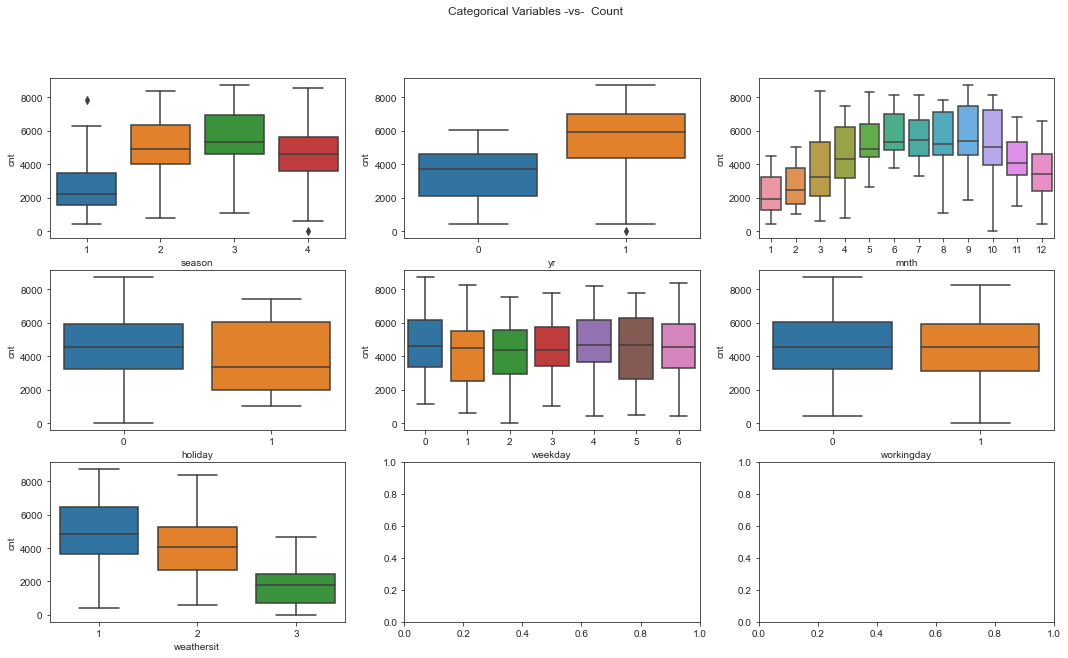

In [10]:
# Plotting categorical variables. 
catvars = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']

fig, axes = plt.subplots(3, 3, figsize=(18, 10))
fig.suptitle('Categorical Variables -vs-  Count')

sns.boxplot(ax=axes[0, 0], data=df, x='season',     y='cnt')
sns.boxplot(ax=axes[0, 1], data=df, x='yr',         y='cnt')
sns.boxplot(ax=axes[0, 2], data=df, x='mnth',       y='cnt')
sns.boxplot(ax=axes[1, 0], data=df, x='holiday',    y='cnt')
sns.boxplot(ax=axes[1, 1], data=df, x='weekday',    y='cnt')
sns.boxplot(ax=axes[1, 2], data=df, x='workingday', y='cnt')
sns.boxplot(ax=axes[2, 0], data=df, x='weathersit', y='cnt')

plt.show()

### Observations on Categorical Features

- There is a significant difference in 'cnt' from 2018 to 2019
- Distribution of 'cnt' is almost similar for all weekdays and workingday. So we could ignore these fields for further analysis. 
- Distribution of 'cnt' on 'holidays' seems to have a different distribution than regular days.
- Worse weather conditions impact the 'cnt' of bikes sold. 
- Season (or its more granular data in terms of 'months') definitely impacts the 'cnt'. 

### Season vs Months
- Each Season is a summarization of almost 3-4 months data. 
- We see the same patterns for cnt distribution across season as in months. 
- That is, there is strong correlation between seasons and months. One of them can be eliminated. 
- To keep our model simple, we will prefer to eliminate the "months" (12 vars) and instead keep seasons (4 vars).


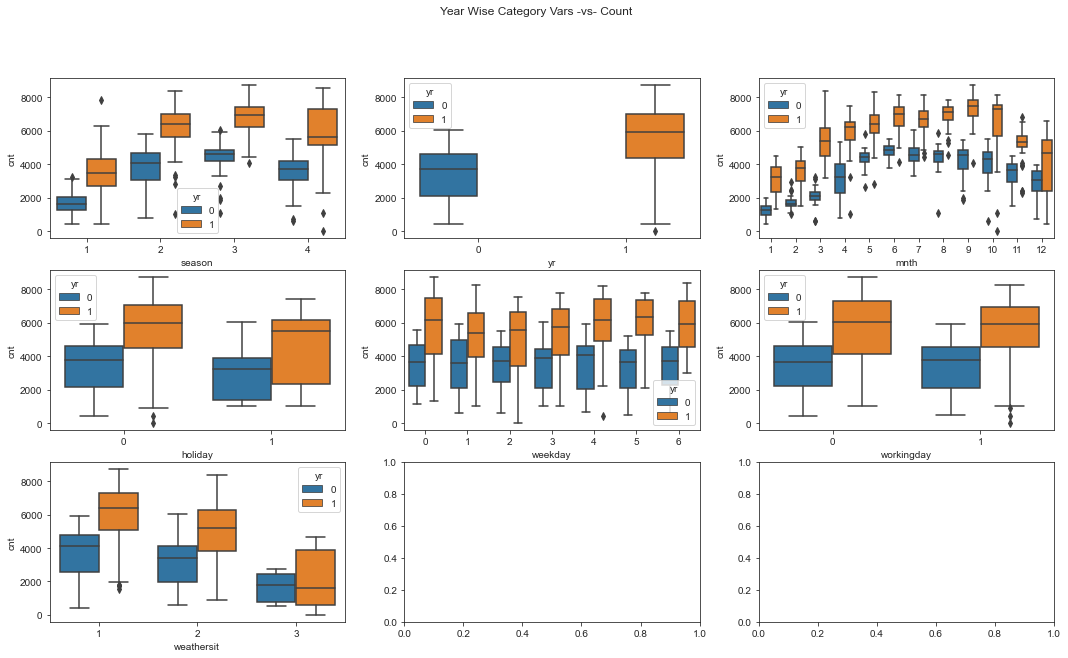

In [11]:
# Let's check if yearly increase is across all (relevant) categorical variables. 
fig, axes = plt.subplots(3, 3, figsize=(18, 10))
fig.suptitle('Year Wise Category Vars -vs- Count')

sns.boxplot(ax=axes[0, 0], data=df, x='season',     y='cnt', hue='yr')
sns.boxplot(ax=axes[0, 1], data=df, x='yr',         y='cnt', hue='yr')
sns.boxplot(ax=axes[0, 2], data=df, x='mnth',       y='cnt', hue='yr')
sns.boxplot(ax=axes[1, 0], data=df, x='holiday',    y='cnt', hue='yr')
sns.boxplot(ax=axes[1, 1], data=df, x='weekday',    y='cnt', hue='yr')
sns.boxplot(ax=axes[1, 2], data=df, x='workingday', y='cnt', hue='yr')
sns.boxplot(ax=axes[2, 0], data=df, x='weathersit', y='cnt', hue='yr')

plt.show()

### Observations: 
As can be clearly see, there's been a general increase of count over the two years regardless of the categorical variable we consider. 

In [12]:
# Dropping columns as per above observations. 
df = df.drop(['weekday', 'workingday', 'mnth'], axis=1)

## Numerical Variables

In [13]:
# Now let's look at the numerical variables vs Cnt
print(df.columns)
# We can also eliminate unnecessary columns like:
# - instant (which is just like our index)
# - dteday (it's an increasing order of dates that give no additional information)

Index(['instant', 'dteday', 'season', 'yr', 'holiday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt'], dtype='object')


In [14]:
df = df.drop(['instant', 'dteday'], axis=1)
numvars = ['temp', 'atemp', 'hum', 'windspeed', 'cnt']

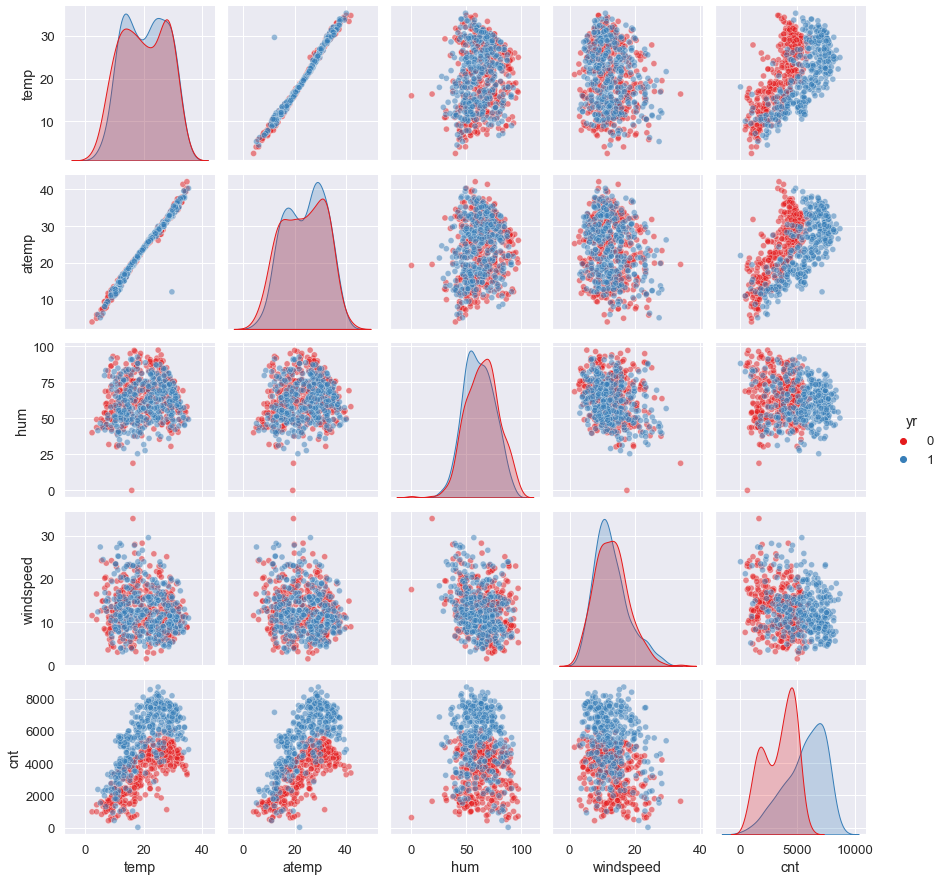

In [15]:
# Plotting numerical variables against cnt ... but segregated by "yearly" data. 
sns.set(font_scale=1.2)
sns.pairplot(data=df[numvars + ['yr']], hue='yr', plot_kws={'alpha':0.5}, palette='Set1')
plt.show()

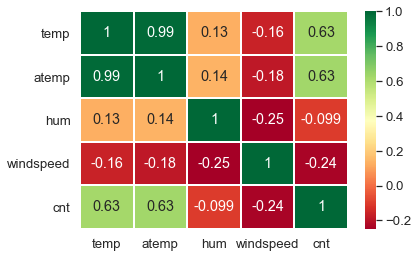

In [16]:
sns.heatmap(data=df[numvars].corr(), annot = True, cmap="RdYlGn", linewidth =1)
plt.show()

### Observations:
- Year wise, only the 'cnt' is impacted. Weather conditions across both years show the same trends (diagonal KDE graphs). 

- The count shows some linear regression with 'temp' & 'atemp'.  There's very strong correlation between temp-vs-atemp. We will examine these later and eliminate one of them. 

- There seems to be no impact of humidity and windspeed on the count of bikes sold. We can eliminate these features. 

In [17]:
# Dropping humidity and windspeed as these seem to have no impact on count. 
df = df.drop(['hum', 'windspeed'], axis=1)

# Data Preparation for Model Building

## Convert Categorical Features to Dummy Numerical Columns

In [18]:
# Convert categorical columns to dummy variables. Currently our categorical columns are already marked as 1,2,3... 
# Lets convert them to actual text first. 
df.columns

Index(['season', 'yr', 'holiday', 'weathersit', 'temp', 'atemp', 'cnt'], dtype='object')

In [19]:
# Convert season column
MapFeatureVals(df, 'season', {1:'spring', 2:'summer', 3:'fall', 4:'winter'})
df = MakeDummyCols(df, 'season')
df.head()

,yr,holiday,weathersit,temp,atemp,cnt,fall,spring,summer,winter
0,0,0,2,14.110847,18.18125,985,0,1,0,0
1,0,0,2,14.902598,17.68695,801,0,1,0,0
2,0,0,1,8.050924,9.47025,1349,0,1,0,0
3,0,0,1,8.200000,10.60610,1562,0,1,0,0
4,0,0,1,9.305237,11.46350,1600,0,1,0,0


In [20]:
# yr & holiday are already like a numerical column with just 0 / 1.

In [21]:
# Let's convert categorical column 'weathersit' to numerical columns. 
MapFeatureVals(df, 'weathersit', {1:'Clear', 2:'Cloudy', 3:'Rainy', 4:'Stormy'})
df = MakeDummyCols(df, 'weathersit')
df.head()

,yr,holiday,temp,atemp,cnt,fall,spring,summer,winter,Clear,Cloudy,Rainy
0,0,0,14.110847,18.18125,985,0,1,0,0,0,1,0
1,0,0,14.902598,17.68695,801,0,1,0,0,0,1,0
2,0,0,8.050924,9.47025,1349,0,1,0,0,1,0,0
3,0,0,8.200000,10.60610,1562,0,1,0,0,1,0,0
4,0,0,9.305237,11.46350,1600,0,1,0,0,1,0,0


## Split Data into Train / Test Sets

In [22]:
# Splitting data into training and testing sets. 
from sklearn.model_selection import train_test_split

# We specify this so that the train and test data set always have the same rows, respectively
np.random.seed(0)
df_train, df_test = train_test_split(df, train_size = 0.7, test_size = 0.3, random_state = 100)

In [23]:
y_train = df_train.loc[:, df_train.columns == 'cnt']
X_train = df_train.loc[:, df_train.columns != 'cnt']

y_test = df_test.loc[:, df_test.columns == 'cnt']
X_test = df_test.loc[:, df_test.columns != 'cnt']

## Scale the Data

Given the simple linear regression we are doing, and not noticing extremely large scales for any columns, we do not see a need for scaling the data in this analysis. 

# Linear Regression Models

## RFE

In [24]:
# Run RFE to find most relevant columns. 
# This will give us a semi-accurate idea of which features are important. 
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# Running RFE with the output number of the variable equal to 10
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 20)             # running RFE
rfe = rfe.fit(X_train, y_train)

list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('yr', True, 1),
 ('holiday', True, 1),
 ('temp', True, 1),
 ('atemp', True, 1),
 ('fall', True, 1),
 ('spring', True, 1),
 ('summer', True, 1),
 ('winter', True, 1),
 ('Clear', True, 1),
 ('Cloudy', True, 1),
 ('Rainy', True, 1)]

### Observations: 
- RFE shows all columns to be significant in the modeling. 
- Hence, we will further analyze these columns with regression and VIF values. 

## Model 1  (Best Possible Model .. All Relevant Variables Included)

### Checking VIF

Variance Inflation Factor or VIF, gives a basic quantitative idea about how much the feature variables are correlated with each other. It is an extremely important parameter to test our linear model. The formula for calculating `VIF` is:

### $ VIF_i = \frac{1}{1 - {R_i}^2} $

In [25]:
GetCurrentVIF(X_train)

   Features    VIF
4      fall    inf
5    spring    inf
6    summer    inf
7    winter    inf
8     Clear    inf
9    Cloudy    inf
10    Rainy    inf
2      temp  55.62
3     atemp  50.83
0        yr   1.02
1   holiday   1.01


In [26]:
X_train.columns

Index(['yr', 'holiday', 'temp', 'atemp', 'fall', 'spring', 'summer', 'winter', 'Clear', 'Cloudy', 'Rainy'], dtype='object')

In [27]:
# MODEL 1  -- All columns of X_train
X_train_lm = X_train[X_train.columns]
lm1 = TrainingStatistics(X_train_lm, y_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     238.2
Date:                Sun, 05 Sep 2021   Prob (F-statistic):          1.59e-174
Time:                        21:21:30   Log-Likelihood:                -4162.6
No. Observations:                 510   AIC:                             8345.
Df Residuals:                     500   BIC:                             8388.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         70.1101    127.319      0.551      0.5

### Observation
- Fall has the highest p-value ... 0.866.  So we will remove 'fall' and redo our model. 

## Model 2

In [28]:
# MODEL 2
X_train = X_train.drop(['fall'], axis=1)


In [29]:
GetCurrentVIF(X_train)

  Features    VIF
2     temp  55.62
3    atemp  50.83
7    Clear  34.23
8   Cloudy  18.48
4   spring   4.50
6   winter   3.09
9    Rainy   2.46
5   summer   2.06
0       yr   1.02
1  holiday   1.01


In [30]:
# MODEL 1  -- All columns of X_train
X_train_lm = X_train[X_train.columns]
lm2 = TrainingStatistics(X_train_lm, y_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     238.2
Date:                Sun, 05 Sep 2021   Prob (F-statistic):          1.59e-174
Time:                        21:21:30   Log-Likelihood:                -4162.6
No. Observations:                 510   AIC:                             8345.
Df Residuals:                     500   BIC:                             8388.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         86.3799    211.465      0.408      0.6

### Observation:
- Even though 'const' has highest p-value, 'const' will keep getting added to the model so we don't remove that.
- Next best candidate is 'atemp' to remove with p-value of 0.203 (which is much greater than 0.05)

## Model 3

In [31]:
X_train = X_train.drop(['atemp'], axis=1)

In [32]:
GetCurrentVIF(X_train)

  Features    VIF
6    Clear  33.90
7   Cloudy  18.29
3   spring   4.46
2     temp   3.29
5   winter   2.97
8    Rainy   2.46
4   summer   2.00
0       yr   1.02
1  holiday   1.01


In [33]:
X_train_lm = X_train[X_train.columns]
lm3 = TrainingStatistics(X_train_lm, y_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     267.5
Date:                Sun, 05 Sep 2021   Prob (F-statistic):          2.11e-175
Time:                        21:21:31   Log-Likelihood:                -4163.4
No. Observations:                 510   AIC:                             8345.
Df Residuals:                     501   BIC:                             8383.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        107.4112    210.952      0.509      0.6

### Observation
- Clear and Cloudy have high VIF ... we will drop one with highest VIF value (Clear)
- Summer (p-val = 0.07) is also a next best candidate for elimination. 

## Model 4 (Final Model)

In [34]:
X_train = X_train.drop(['Clear', 'summer'], axis=1)

In [35]:
GetCurrentVIF(X_train)

  Features   VIF
2     temp  2.35
0       yr  2.05
5   Cloudy  1.49
4   winter  1.30
3   spring  1.22
6    Rainy  1.06
1  holiday  1.04


In [36]:
X_train_lm = X_train[X_train.columns]
lm4 = TrainingStatistics(X_train_lm, y_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     303.9
Date:                Sun, 05 Sep 2021   Prob (F-statistic):          5.74e-176
Time:                        21:21:31   Log-Likelihood:                -4165.0
No. Observations:                 510   AIC:                             8346.
Df Residuals:                     502   BIC:                             8380.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1534.2638    213.648      7.181      0.0

## Analysis of Final Model

<AxesSubplot:>

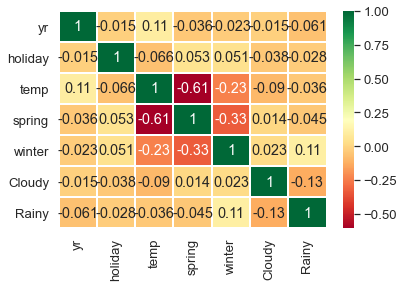

In [37]:
# Above Model-4 seems fairly good. But let's confirm once more for any hidden correlations 
# among our model variables. 

sns.heatmap(X_train.corr(), annot = True, cmap="RdYlGn", linewidth =1)

### Observations:
- Heatmap shows a decent, but not very strong, negative correlation between 'Spring' and 'temp'.  However, we will retain both as the VIF values for both is less than 5. 
- We are not seeing any variable with more than 0.05 p-value. 
- Also, the R2 and adjusted R2 values are fairly close and account for almost 80+ % of the variation in cnt.  These values are on par with the best possible Model-1.  That is R2 values are .807 (in best model) vs .806 (in final model)
- Hence, we conclude this is a fairly good model. 

### <font color='green'> cnt = constant  + c1.yr + c2.holiday + c3.temp + c4.spring + c5.winter + c6.Cloudy + c7.Rainy </font>

where: 
- constant = 1543.3
- c1 =   2031.0
- c2 =   -792.2
- c3 =    117.8
- c4 =  -1034.0
- c5 =    484.2
- c6 =   -644.2
- c7 =  -2570.9


### Observations on our Model
- We observe NEGATIVE coefficients when 'holiday', 'spring', 'Cloudy' and 'Rainy' variables are true. 
- Maximum positive impact is from the yearly increase in sales. 

# Validation/Prediction of Model for Test Data

## Equate features in X_test and X_train

In [38]:
print(X_test.columns)
print(X_train.columns)

Index(['yr', 'holiday', 'temp', 'atemp', 'fall', 'spring', 'summer', 'winter', 'Clear', 'Cloudy', 'Rainy'], dtype='object')
Index(['yr', 'holiday', 'temp', 'spring', 'winter', 'Cloudy', 'Rainy'], dtype='object')


In [39]:
X_test = X_test.drop(['atemp', 'fall', 'summer', 'Clear'], axis=1)

## Predicting Cnt for Test DataSet (X_test)

In [40]:
# Making predictions using the Test data set. i.e., X_test
X_test = sm.add_constant(X_test)
cnt_pred = lm4.predict(X_test)

In [41]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test.cnt, cnt_pred)
r_squared = r2_score(y_test.cnt, cnt_pred)
print(np.sqrt(mse))
print(r_squared)

832.9908653620562
0.8066314855051608


In [42]:
np.std(df.cnt)

1934.685157553342

### Observation:
- RMSE is around 832 bikes ... which is much less than standard deviation of cnt. 
- Also, R2 value of 0.8 shows there is a fair amount of correlation between actual values of cnt and those predicted by our model. 

In [43]:
X_test.shape

(219, 8)

# Prove Model follows Assumption of Linear Regression

### Validating the assumption of Linear Regression Model :

- Linear Relationship
- Homoscedasticity
- Absence of Multicollinearity
- Independence of residuals
- Normality of Errors

## Linear Relationship

We will test the linear relationship of our model with respect to one of the numerical features. 

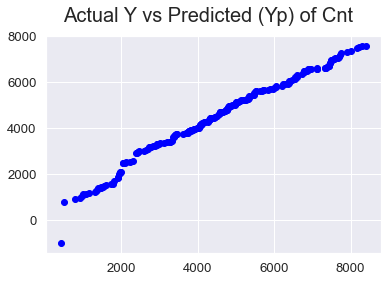

In [44]:
# We will plot  our predicted y values vs actual y values. 
# They should have linear relationship. 

# Sorted values of Actual Y's and Predicted Y's
y_sort  = y_test.cnt.sort_values()
yp_sort = cnt_pred.sort_values()

# Plot of y-pred vs actual y.
c = [i for i in range(1,220,1)]
fig = plt.figure()
plt.scatter(y_sort, yp_sort, color="blue")
fig.suptitle('Actual Y vs Predicted (Yp) of Cnt', fontsize=20) 
plt.show()

## Homoscedasticity (equal distribution of errors)

In [45]:
# Homoscedasticity means that standard residuals are evenly distributed. 

df2 = pd.DataFrame({'Y':y_test.cnt,  'Ypred': cnt_pred})

df2['Residual'] = df2.Y - df2.Ypred
mean = df2['Residual'].mean()
std  = df2["Residual"].std()
df2["StdResidual"] = (df2["Residual"] - mean)/std

df2.head()

,Y,Ypred,Residual,StdResidual
184,6043,3608.042486,2434.957514,2.868318
535,6211,7345.128557,-1134.128557,-1.412383
299,2659,3644.566674,-985.566674,-1.234201
221,4780,5237.644058,-457.644058,-0.601019
152,4968,4988.066927,-20.066927,-0.076197


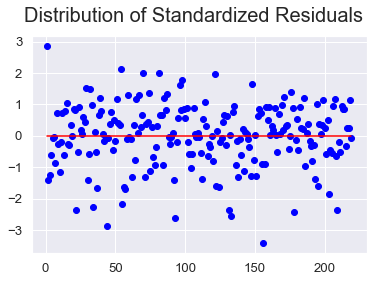

In [46]:
# Distribution of Errors (y - ypred) around the x axis. 
c = [i for i in range(1,220,1)]
fig = plt.figure()
# Plot actual cnt values
plt.scatter(c, df2.StdResidual, color="blue")
plt.plot(c, cnt_pred - cnt_pred, color='red')
fig.suptitle('Distribution of Standardized Residuals', fontsize=20) 
plt.show()


### Observation
- The standardized residuals are evenly spread around the x axis for all data points. 

## Absence of Multicolinearity

In [47]:
GetCurrentVIF(X_test)

# We don't observe any feature with > 5 VIF. 
# Hence, there is no Multicolinearity among our test data.

  Features    VIF
0    const  35.06
4   spring   2.84
3     temp   2.67
5   winter   1.70
7    Rainy   1.05
1       yr   1.03
6   Cloudy   1.03
2  holiday   1.01


## Independence of Residuals

Residual by predicted plot. This is a graph of each residual value plotted against the corresponding predicted value.

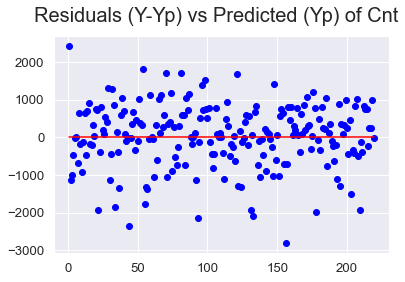

In [48]:
# Plot of Residuals vs Predictions.
c = [i for i in range(1,220,1)]
fig = plt.figure()
# Plot actual cnt values
plt.scatter(c, y_test.cnt - cnt_pred, color="blue")
plt.plot(c, cnt_pred - cnt_pred, color='red')
fig.suptitle('Residuals (Y-Yp) vs Predicted (Yp) of Cnt', fontsize=20) 
plt.show()

### Observation:
- The distribution of ERRORS (y - ypred) is randomly distributed evenly around the y=0 axis for all rows of test data. Hence, the residuals are independent of each other. 


## Normality of Errors

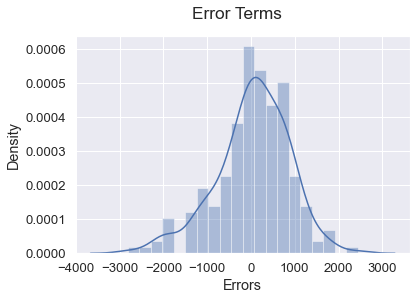

In [49]:
res = y_test.cnt - cnt_pred

# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((res), bins = 20)
fig.suptitle('Error Terms')
plt.xlabel('Errors')
plt.show()

### Observation
- The residual errors are normally distributed with mean = 0. 
- Hence, it satisfies the normality condition for linear regression. 

# Business Recommendations

## Pattern Analysis of Rainy/Cloudy Conditions. 

In [50]:
df3 = pd.read_csv('day.csv')
df3.weathersit.value_counts()

1    463
2    246
3     21
Name: weathersit, dtype: int64

We see that there rarely any adverse (Rainy) weather ... only 21 days in a period of 2 years. 

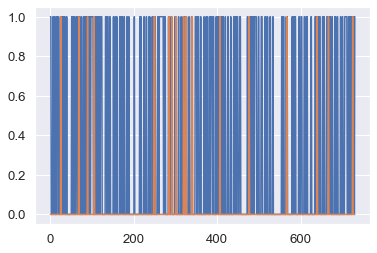

In [51]:
# Plotting Rainy and Cloudy days. 
plt.plot(df.index, df.Cloudy)
plt.plot(df.index, df.Rainy)

- Mostly clear weather (almost 2/3 the days)
- There are plenty of cloudy days (almost 1/3 rd). 
- Almost negligible rainy days (< 3% of the days)

## Relevant Variables Impacting Business

### <font color='green'> cnt = constant  + c1.yr + c2.holiday + c3.temp + c4.spring + c5.winter + c6.Cloudy + c7.Rainy </font>

where: 

| Coefficient | Value       |  Field    |
|-------------|-------------|-----------|
| constant    |   1543.3    |           |
| c1          |   2031.0    | Year      |
| c2          |   -792.2    | Holidays  |
| c3          |    117.8    | Temprature|
| c4          |  -1034.0    | Spring    |
| c5          |    484.2    | Winter    |
| c6          |   -644.2    | Cloudy    |
| c7          |  -2570.9    | Rainy     |

### Observations:
- Highest negative impact on business is a 'rainy' weather (or even 'cloudy' weather when it might seem like it's going to rain). Cycle sales are down by average of 2571 units when it's raining. 
- Also, 'Spring' season and special 'Holidays' reduces sale of cycles. 


### Recommendations based on seasons / holiday
- We can know in advance, when it's going to be a holiday or season like Winter/Spring. 
- On these days (Holidays, Spring Season), offer special discounts to raise sales. 

### Recommendations based on weather
- Trying to improve business on the Rainy days ( < 3% days) is meaningless and not predictable either. 
- Business is fairly good on 'Clear' days ... so no need to give any special incentives here. 
- Buisness is impacted by 'Cloudy' days (almost 1/3rd days).  Hence, provide 'Promotional Values' on cloudy days. 
